In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import tiktoken as tk

In [2]:
import sys
sys.path.append('/content/drive/My Drive/LLM/Notebooks')

In [25]:
import urllib.request
from pathlib import Path
import json
import time
import os
from tqdm import tqdm
from functools import partial
import math

In [4]:
from gpt_download import download_and_load_gpt2
from gpt2 import *
from utils import *

# **Data Preparation**

In [5]:
def download_and_load_file(file_path, url):
  if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
      text_data = response.read().decode("utf-8")
    with open(file_path, 'w', encoding='utf-8') as f:
      f.write(text_data)
  else:
    with open(file_path, 'r', encoding='utf-8') as f:
      text_data = f.read()
  with open(file_path, 'r') as f:
    data = json.load(f)
  return data

In [6]:
file_path = '/content/drive/My Drive/LLM/Data/instruction-data.json'
url = 'https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json'

data = download_and_load_file(file_path, url)
print("Total entries: ", len(data))

Total entries:  1100


In [7]:
def split_data(data, train_size, test_size):
  train_data = data[:int(len(data) * train_size)]
  test_data = data[int(len(data) * train_size) : int(len(data) * (train_size + test_size))]
  val_data = data[int(len(data) * (train_size + test_size)):]

  return train_data, val_data, test_data

In [8]:
train_data, val_data, test_data = split_data(data, 0.85, 0.1)

In [9]:
def format_entry(entry):
  instruction_text = (
      f"Below is the instruction that describes a task. Write an appropriate response to address the instruction. "
      f"\n\n### Instruction:\n{entry['instruction']}"
  )

  input_text = f"\n\n### Input:\n{entry['input']}" if entry['input'] else ""

  return instruction_text + input_text

In [10]:
class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data
    self.entry_lst = []

    for entry in self.data:
      instruction_text = format_entry(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      text = instruction_text + response_text

      encoded_text = tokenizer.encode(text)
      self.entry_lst.append(encoded_text)

  def __getitem__(self, idx):
    return self.entry_lst[idx]

  def __len__(self):
    return len(self.entry_lst)

In [11]:
tokenizer = tk.get_encoding('gpt2')

In [12]:
def custom_collate_fn(batch, pad_token_id = 50256, ignore_index=-100, allowed_max_length=1024, device='cpu'):
  batch_max_length = max([len(item)+1 for item in batch])
  inputs_lst, targets_lst = [], []

  for item in batch:
    new_item = item.copy()
    new_item += [pad_token_id]

    padded_item = new_item + [pad_token_id] * (batch_max_length - len(new_item))

    input = padded_item[:-1]
    target = padded_item[1:]

    input = torch.tensor(input)
    target = torch.tensor(target)

    mask = target == pad_token_id
    indices = torch.nonzero(mask).squeeze()
    if indices.numel() > 1:
      target[indices[1:]] = ignore_index

    if allowed_max_length is not None:
      input = input[:allowed_max_length]
      target = target[:allowed_max_length]

    inputs_lst.append(input)
    targets_lst.append(target)

  return torch.stack(inputs_lst).to(device), torch.stack(targets_lst).to(device)


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
customized_collate_fn = partial(custom_collate_fn, pad_token_id = 50256, ignore_index=-100, allowed_max_length=1024, device=device)

In [35]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=customized_collate_fn, num_workers=num_workers)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=customized_collate_fn, num_workers=num_workers)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=customized_collate_fn, num_workers=num_workers)

In [37]:
for x,y in train_loader:
  print(x.shape, y.shape)

torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 59]) torch.Size([8, 59])
torch.Size([8, 62]) torch.Size([8, 62])


# **Load Pretrained weights**

In [17]:
model_name = 'gpt2-medium (355M)'
model_size = model_name.split(' ')[-1].lstrip('(').rstrip(')')
BASE_CONFIG.update(model_configs[model_name])

In [18]:
settings, params = download_and_load_gpt2(model_size, models_dir='gpt')

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 172kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.07MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 169kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [01:36<00:00, 14.6MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 13.2MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 2.64MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.51MiB/s]


In [38]:
model = GPTModel(BASE_CONFIG)
load_parameters(model, params)
model.eval()

GPTModel(
  (token_emb_layer): Embedding(50257, 1024)
  (pos_emb_layer): Embedding(1024, 1024)
  (dropout_layer): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_query): Linear(in_features=1024, out_features=1024, bias=True)
        (w_key): Linear(in_features=1024, out_features=1024, bias=True)
        (w_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GeLU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (mha): MultiHeadAttention(
 

In [39]:
#lets calculate loss before adding lora weights
torch.manual_seed(123)
model.to(device)

with torch.no_grad():
  train_loss = calc_loss_dataloader(train_loader, model, device, 5)
  val_loss = calc_loss_dataloader(val_loader, model, device, 5)

print(f"Training loss: {train_loss}")
print(f"Validation loss : {val_loss}")

Training loss: 3.8755919456481935
Validation loss : 3.8087229251861574


# **Add LoRA weights to Linear layers**

In [40]:
class LoRA(nn.Module):
  def __init__(self, in_size, out_size, rank, alpha):
    super().__init__()
    self.alpha = alpha
    self.A = nn.Parameter(torch.empty(in_size, rank))
    nn.init.kaiming_uniform_(self.A, a=math.sqrt(5)) #weight initialization, this fn is called inside Linear module for weight initialization
    self.B = nn.Parameter(torch.zeros(rank, out_size))

  def forward(self, x):
    return self.alpha * (x @ self.A @ self.B)

In [41]:
#module to replace the linear layer
class LinearWithLoRA(nn.Module):
  def __init__(self, linear, rank, alpha):
    super().__init__()
    self.linear = linear
    self.lora = LoRA(linear.in_features, linear.out_features, rank, alpha)

  def forward(self, x):
    return self.linear(x) + self.lora(x)

In [42]:
def replace_linear_with_lora(model, alpha, rank):
  for name, module in model.named_children():
    if isinstance(module, nn.Linear):
      setattr(model, name, LinearWithLoRA(module, rank, alpha))
    else:
      replace_linear_with_lora(module, rank, alpha)

In [43]:
rank=16
alpha=16
trainable_params_before = sum(param.numel() for param in model.parameters() if param.requires_grad)
#lets freeze the weights
for param in model.parameters():
  param.requires_grad = False
replace_linear_with_lora(model, rank=rank, alpha=alpha)
trainable_params_after = sum(param.numel() for param in model.parameters() if param.requires_grad)

print(f"Trainable parameters before freezing pretrained weights: {trainable_params_before}")
print(f"Trainable parameters after freezing the pretrained weights and adding LoRA weights: {trainable_params_after}")

Trainable parameters before freezing pretrained weights: 406286336
Trainable parameters after freezing the pretrained weights and adding LoRA weights: 7898384


# **Fine-Tuning**

In [45]:
#lets calculate loss before fine-tuning the model
torch.manual_seed(123)
model.to(device)

with torch.no_grad():
  train_loss = calc_loss_dataloader(train_loader, model, device, 5)
  val_loss = calc_loss_dataloader(val_loader, model, device, 5)

print(f"Training loss: {train_loss}")
print(f"Validation loss : {val_loss}")

Training loss: 3.8755919456481935
Validation loss : 3.8087229251861574


In [46]:
#fine-tune
torch.manual_seed(123)

t0 = time.time()

epochs = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

train_losses, val_losses, track_tokens_seen = train_model_simple(model, train_loader, val_loader, device, optimizer, epochs, eval_freq=5, eval_iter=5, start_context=format_entry(val_data[0]), tokenizer=tokenizer)

t1 = time.time()

exec_time = (t1 - t0)/60 # in minutes

print(f"Training completed in {exec_time} mins")

Train loss after epoch 0 (Step: 0): 2.658
Val loss after epoch 0 (Step: 0): 2.668
Number of tokens seen after epoch 0 (Step: 0)
Train loss after epoch 0 (Step: 5): 1.192
Val loss after epoch 0 (Step: 5): 1.105
Number of tokens seen after epoch 0 (Step: 5)
Train loss after epoch 0 (Step: 10): 0.902
Val loss after epoch 0 (Step: 10): 0.991
Number of tokens seen after epoch 0 (Step: 10)
Train loss after epoch 0 (Step: 15): 0.866
Val loss after epoch 0 (Step: 15): 0.949
Number of tokens seen after epoch 0 (Step: 15)
Train loss after epoch 0 (Step: 20): 0.799
Val loss after epoch 0 (Step: 20): 0.921
Number of tokens seen after epoch 0 (Step: 20)
Train loss after epoch 0 (Step: 25): 0.772
Val loss after epoch 0 (Step: 25): 0.884
Number of tokens seen after epoch 0 (Step: 25)
Train loss after epoch 0 (Step: 30): 0.803
Val loss after epoch 0 (Step: 30): 0.854
Number of tokens seen after epoch 0 (Step: 30)
Train loss after epoch 0 (Step: 35): 0.727
Val loss after epoch 0 (Step: 35): 0.821
Numbe

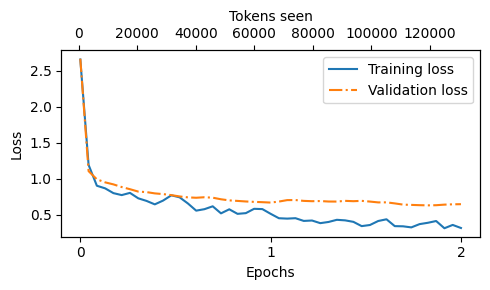

In [47]:
epochs_tensor = torch.linspace(0, epochs, len(train_losses))
plot_losses(
    epochs_tensor, track_tokens_seen,
    train_losses,
    val_losses
    )

In [48]:
#lets test the fine-tuned model on test data
for entry in test_data[:3]:
  formatted_entry = format_entry(entry)
  output_tokens = generate(
      model=model,
      inp_tokens=text_to_token_ids(formatted_entry, tokenizer).to(device),
      context_size=BASE_CONFIG['context_length'],
      max_tokens=256,
      eos_id=50256
  )
  output_text = token_ids_to_text(output_tokens, tokenizer)
  response_text = output_text[len(formatted_entry):].replace("### Response:",'').strip()
  print(formatted_entry)
  print(f"Correct Response: {entry['output']}")
  print(f'Model Response: {response_text}\n\n\n')


Below is the instruction that describes a task. Write an appropriate response to address the instruction. 

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.
Correct Response: The car is as fast as lightning.
Model Response: The car is as fast as an elephant.



Below is the instruction that describes a task. Write an appropriate response to address the instruction. 

### Instruction:
What type of cloud is typically associated with thunderstorms?
Correct Response: The type of cloud typically associated with thunderstorms is cumulonimbus.
Model Response: The type of cloud typically associated with thunderstorms is a cumulus.



Below is the instruction that describes a task. Write an appropriate response to address the instruction. 

### Instruction:
Name the author of 'Pride and Prejudice'.
Correct Response: Jane Austen.
Model Response: The author of 'Pride and Prejudice' is Jane Austen.





In [49]:
def extract_and_save_responses(data, model, device, tokenizer, destination_path):
  for i, entry in tqdm(enumerate(data), total=len(data)):
    formatted_entry = format_entry(entry)
    output_tokens = generate(
        model=model,
        inp_tokens=text_to_token_ids(formatted_entry, tokenizer).to(device),
        context_size=BASE_CONFIG['context_length'],
        max_tokens=256,
        eos_id=50256
    )
    output_text = token_ids_to_text(output_tokens, tokenizer)
    response_text = output_text[len(formatted_entry):].replace("### Response:",'').strip()

    data[i]['model_response'] = response_text

  with open(destination_path,'w') as file:
    json.dump(data, file, indent=4)

In [50]:
destination_path = f'/content/drive/My Drive/LLM/Data/instruction-data-with-response-lora-rank{rank}.json'
extract_and_save_responses(test_data, model, device, tokenizer, destination_path)

100%|██████████| 110/110 [01:46<00:00,  1.04it/s]
